In [28]:
import constant as c
import functions as f
import pandas as pd
import os
from os.path import join
from itertools import combinations
import numpy as np
from scipy.spatial.distance import euclidean, hamming
import collections

from numpy import matlib

import proxmin
from sklearn.linear_model import LogisticRegression

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.metrics import classification_report, f1_score
from imblearn.metrics import geometric_mean_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

from sklearn.svm import SVR
from sklearn.svm import SVC

from joblib import dump, load

#3 Feature Scaling
import plotly.graph_objects as go
from sklearn.metrics import recall_score
from imblearn.metrics import specificity_score

%matplotlib inline


In [29]:
ant_dataframe = []
camel_dataframe = []
ivy_dataframe = []
jedit_dataframe = []
lucene_dataframe = []
poi_dataframe = []
synapse_dataframe = []
velocity_dataframe = []
xalan_dataframe = []
xerces_dataframe = []
log4j_dataframe = []


for filename in os.listdir(c.ant):
    tmp = pd.read_csv(join(c.ant, filename))
    ant_dataframe.append(tmp)

for filename in os.listdir(c.camel):
    tmp = pd.read_csv(join(c.camel, filename))
    camel_dataframe.append(tmp)
    
for filename in os.listdir(c.ivy):
    tmp = pd.read_csv(join(c.ivy, filename))
    ivy_dataframe.append(tmp)   
    
for filename in os.listdir(c.jedit):
    tmp = pd.read_csv(join(c.jedit, filename))
    jedit_dataframe.append(tmp)
    
for filename in os.listdir(c.lucene):
    tmp = pd.read_csv(join(c.lucene, filename))
    lucene_dataframe.append(tmp)
    
for filename in os.listdir(c.poi):
    tmp = pd.read_csv(join(c.poi, filename))
    poi_dataframe.append(tmp)
    
for filename in os.listdir(c.synapse):
    tmp = pd.read_csv(join(c.synapse, filename))
    synapse_dataframe.append(tmp)    
    
for filename in os.listdir(c.velocity):
    tmp = pd.read_csv(join(c.velocity, filename))
    velocity_dataframe.append(tmp)   
    
for filename in os.listdir(c.xalan):
    tmp = pd.read_csv(join(c.xalan, filename))
    xalan_dataframe.append(tmp)
    
for filename in os.listdir(c.xerces):
    tmp = pd.read_csv(join(c.xerces, filename))
    xerces_dataframe.append(tmp)

for filename in os.listdir(c.log4j):
    tmp = pd.read_csv(join(c.log4j, filename))
    log4j_dataframe.append(tmp)

    

ant_dataframe = pd.concat(ant_dataframe)
camel_dataframe = pd.concat(camel_dataframe)
ivy_dataframe = pd.concat(ivy_dataframe)
jedit_dataframe = pd.concat(jedit_dataframe)
lucene_dataframe = pd.concat(lucene_dataframe)
poi_dataframe = pd.concat(poi_dataframe)
synapse_dataframe = pd.concat(synapse_dataframe)
velocity_dataframe = pd.concat(velocity_dataframe)
xalan_dataframe = pd.concat(xalan_dataframe)
xerces_dataframe = pd.concat(xerces_dataframe)
log4j_dataframe = pd.concat(log4j_dataframe)

In [30]:
needed = ['name', 'wmc', 'dit', 'noc', 'cbo', 'rfc', 'lcom',
       'ca', 'ce', 'npm', 'lcom3', 'loc', 'dam', 'moa', 'mfa', 'cam', 'ic',
       'cbm', 'amc', 'max_cc', 'avg_cc', 'bug']
features_withbug = ['wmc', 'dit', 'noc', 'cbo', 'rfc', 'lcom',
       'ca', 'ce', 'npm', 'lcom3', 'loc', 'dam', 'moa', 'mfa', 'cam', 'ic',
       'cbm', 'amc', 'max_cc', 'avg_cc', 'bug']
features = ['wmc', 'dit', 'noc', 'cbo', 'rfc', 'lcom',
       'ca', 'ce', 'npm', 'lcom3', 'loc', 'dam', 'moa', 'mfa', 'cam', 'ic',
       'cbm', 'amc', 'max_cc', 'avg_cc']


distances = ['e', 'm' , 'c']

In [31]:
all_dataframe = [
                ant_dataframe,
                camel_dataframe,
                ivy_dataframe,
                jedit_dataframe, 
                lucene_dataframe,
                poi_dataframe, 
                synapse_dataframe, 
                velocity_dataframe, 
                xalan_dataframe, 
                #xerces_dataframe,  #VA PRIMA ORDINATO (DA RICORDARE)
                log4j_dataframe
              ]

In [32]:
ant_dataframe
versions = ant_dataframe.version.unique()
names = ant_dataframe.name.unique()
version_tuple = [(x, y) for x, y in zip(versions[0::1],versions[1::1])]

In [33]:
import plotly.express as px


In [34]:
import warnings
warnings.filterwarnings('ignore') 

In [40]:
def run_Regressor(previous, current, idx, ds3 = False,verbose = False, plot = False):
    """
        This function trains and uses model.

        :param D: matrix whose non-zero rows corresponds to the representatives of the dataset.
        :param p: norm to be used to calculate regularization cost.
        :returns: regularization cost.
    """

    scaler = StandardScaler()
    if ds3:
        training_D3 = previous.iloc[idx].reset_index()
        scaler.fit(training_D3[c.features])
        X_train = scaler.transform(training_D3[c.features])
        y_train = training_D3['bug']
        X_test = scaler.transform(current[c.features])
        y_test = current['bug']
    else:
        train = previous
        scaler.fit(train[c.features])
        X_train = scaler.transform(train[c.features])
        y_train = train['bug']
        X_test = scaler.transform(current[c.features])
        y_test = current['bug']
    
    
    tuned_parameters = [{'kernel': ['rbf'], 'gamma':[1, 0.1, 0.01, 0.001, 0.0001],
                     'C': [0.001, 0.01, 0.1, 1, 10]},
                    {'kernel': ['linear'], 'gamma': [1, 0.1, 0.01, 0.001, 0.0001] ,'C': [0.001, 0.01, 0.1, 1, 10]}]
    

    print("# Tuning hyper-parameters for %s" % 'precision')
    print()
    clf = GridSearchCV(
        SVC(), tuned_parameters, scoring='%s_macro' % 'precision'
    )

    clf = clf.fit(X_train, y_train)
    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
#     for mean, std, params in zip(means, stds, clf.cv_results_['params']):
#         print("%0.3f (+/-%0.03f) for %r"
#               % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_predicted = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_predicted))
    print()
    print()
    ##CALCULATE SCORE OF THE MODEL##
    if plot:
        fig = px.scatter(y_test)
        fig.add_trace(go.Scatter(x= list(range(y_test.shape[0])), y= y_predicted))
        fig.show()

    cm = metrics.confusion_matrix(y_test, y_predicted)
    gmean = geometric_mean_score(y_test, y_predicted, average = 'micro')
    #print(cm)
    FP = cm.sum(axis=0) - np.diag(cm)
    FN = cm.sum(axis=1) - np.diag(cm)
    TP = np.diag(cm)
    TN = cm.sum() - (FP + FN + TP)

    # Sensitivity, hit rate, recall, or true positive rate
    #TPR = TP / (TP + FN)
    TPR = recall_score(y_test, y_predicted, average='micro')

    # Fall out or false positive rate
    #FPR = FP / (FP + TN)
    FPR = 1 - (specificity_score(y_test, y_predicted, average='micro'))

    #Balance
    balance = 1 - (np.sqrt((0 - FPR) ** 2 + (1 - TPR) ** 2) / np.sqrt(2))
    balance = np.average(balance)

    ##F MEASURE##
    fmeasure = f1_score(y_test, y_predicted, average = 'micro')
    print('F-Measure : ', fmeasure)
    print('G-Mean :', gmean)
    print('Balance :', balance)
############################################################################
############################################################################
#    'micro':
#     Calculate metrics globally by counting the total true positives, false negatives and false positives.
#
#   'macro':
#     Calculate metrics for each label, and find their unweighted mean. This does not take label imbalance into account.
############################################################################
############################################################################



    '''filename = join(c.MODEL_DIR , 'digits_classifier.joblib.pkl')
    _ = joblib.dump(clf, filename, compress=9)
'''

__________________________
PREVIOUS: 1.3
CURRENT: 1.4
DISTANCE: c
______WITH DS3_____
# Tuning hyper-parameters for precision

Best parameters set found on development set:

{'C': 0.1, 'gamma': 1, 'kernel': 'linear'}

Grid scores on development set:


Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

              precision    recall  f1-score   support

           0       0.78      0.97      0.86       138
           1       0.33      0.06      0.10        35
           2       0.00      0.00      0.00         3
           3       0.00      0.00      0.00         2

    accuracy                           0.76       178
   macro avg       0.28      0.26      0.24       178
weighted avg       0.67      0.76      0.69       178





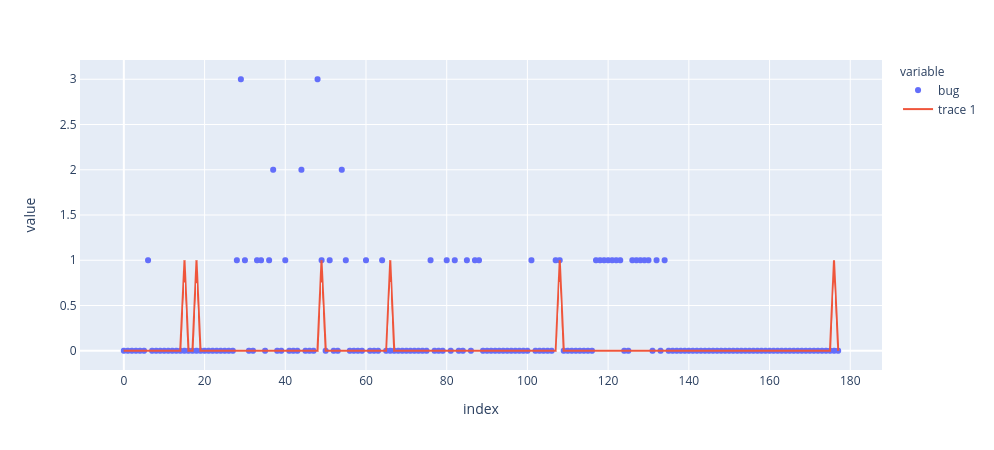

F-Measure :  0.7640449438202248
G-Mean : 0.8390181888806503
Balance : 0.8241294849157469
______WITHOUT DS3______
# Tuning hyper-parameters for precision

Best parameters set found on development set:

{'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}

Grid scores on development set:


Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

              precision    recall  f1-score   support

           0       0.79      0.90      0.84       138
           1       0.45      0.14      0.22        35
           2       0.00      0.00      0.00         3
           3       0.00      0.00      0.00         2

    accuracy                           0.72       178
   macro avg       0.31      0.26      0.26       178
weighted avg       0.70      0.72      0.69       178





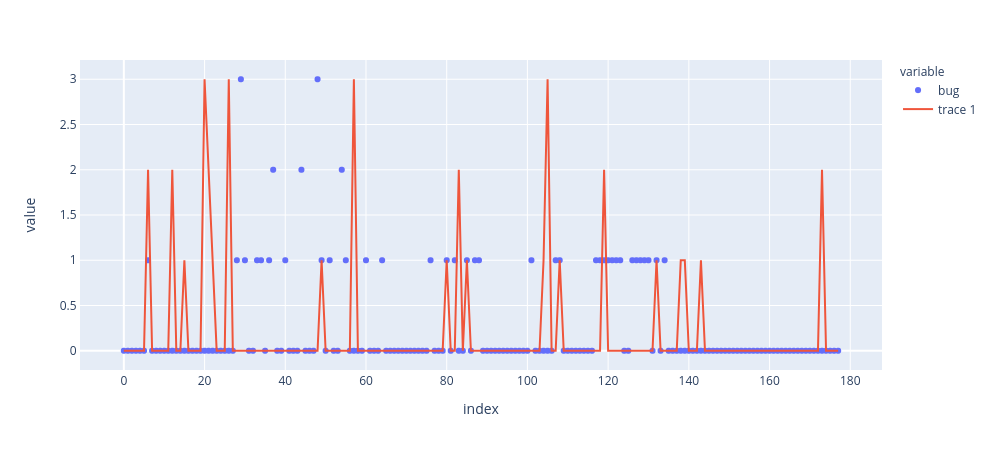

F-Measure :  0.7247191011235955
G-Mean : 0.8113067602702411
Balance : 0.7948177324017047
__________________________
PREVIOUS: 1.4
CURRENT: 1.5
DISTANCE: c
______WITH DS3_____
# Tuning hyper-parameters for precision

Best parameters set found on development set:

{'C': 1, 'gamma': 1, 'kernel': 'rbf'}

Grid scores on development set:


Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

              precision    recall  f1-score   support

           0       0.89      0.96      0.92       261
           1       0.00      0.00      0.00        29
           2       0.00      0.00      0.00         3

    accuracy                           0.86       293
   macro avg       0.30      0.32      0.31       293
weighted avg       0.79      0.86      0.82       293





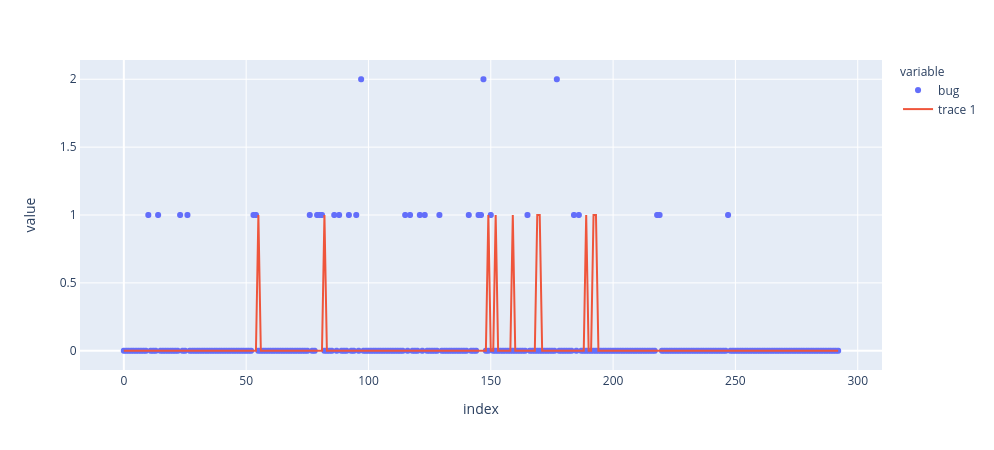

F-Measure :  0.856655290102389
G-Mean : 0.8917717129856715
Balance : 0.886676056546867
______WITHOUT DS3______
# Tuning hyper-parameters for precision

Best parameters set found on development set:

{'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}

Grid scores on development set:


Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

              precision    recall  f1-score   support

           0       0.90      0.85      0.87       261
           1       0.10      0.14      0.11        29
           2       0.00      0.00      0.00         3
           3       0.00      0.00      0.00         0

    accuracy                           0.77       293
   macro avg       0.25      0.25      0.25       293
weighted avg       0.81      0.77      0.79       293





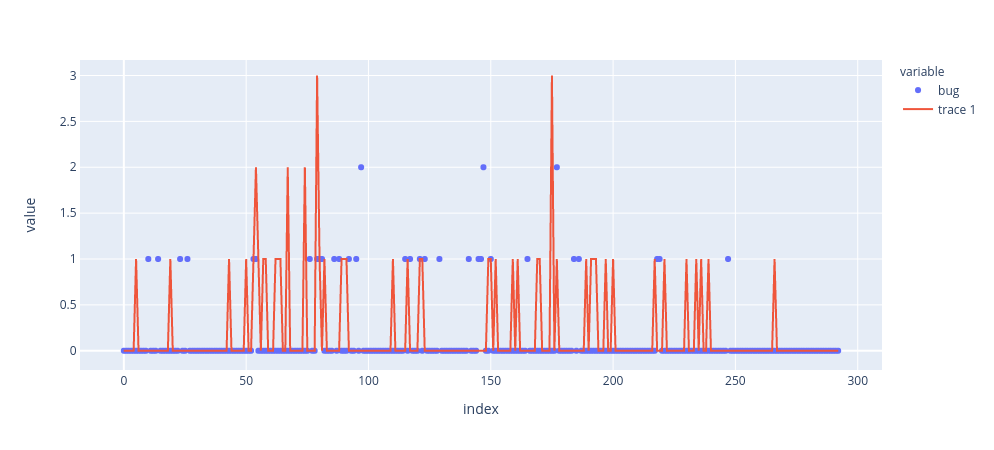

F-Measure :  0.7713310580204779
G-Mean : 0.8441196039085033
Balance : 0.8295602337969444
__________________________
PREVIOUS: 1.5
CURRENT: 1.6
DISTANCE: c
______WITH DS3_____
# Tuning hyper-parameters for precision

Best parameters set found on development set:

{'C': 1, 'gamma': 1, 'kernel': 'rbf'}

Grid scores on development set:


Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

              precision    recall  f1-score   support

           0       0.74      0.99      0.85       259
           1       0.67      0.09      0.15        46
           2       0.00      0.00      0.00        22
           3       0.00      0.00      0.00        17
           4       0.00      0.00      0.00         2
           5       0.00      0.00      0.00         1
           6       0.00      0.00      0.00         2
           8       0.00      0.00      0.00         1
          10       0.00      0.00      0.

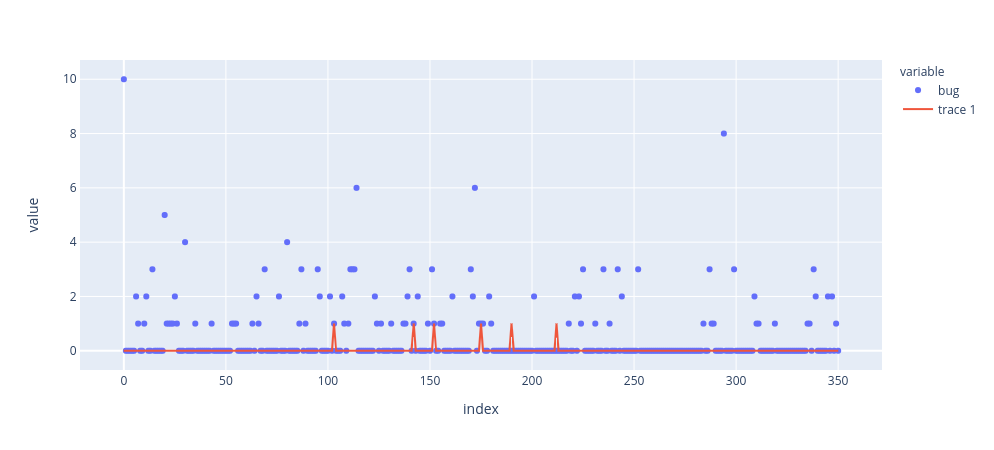

F-Measure :  0.7435897435897437
G-Mean : 0.8483847823879848
Balance : 0.8172795793110357
______WITHOUT DS3______
# Tuning hyper-parameters for precision

Best parameters set found on development set:

{'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}

Grid scores on development set:


Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

              precision    recall  f1-score   support

           0       0.77      0.99      0.87       259
           1       0.29      0.09      0.13        46
           2       0.00      0.00      0.00        22
           3       0.00      0.00      0.00        17
           4       0.00      0.00      0.00         2
           5       0.00      0.00      0.00         1
           6       0.00      0.00      0.00         2
           8       0.00      0.00      0.00         1
          10       0.00      0.00      0.00         1

    accuracy                           0.74 

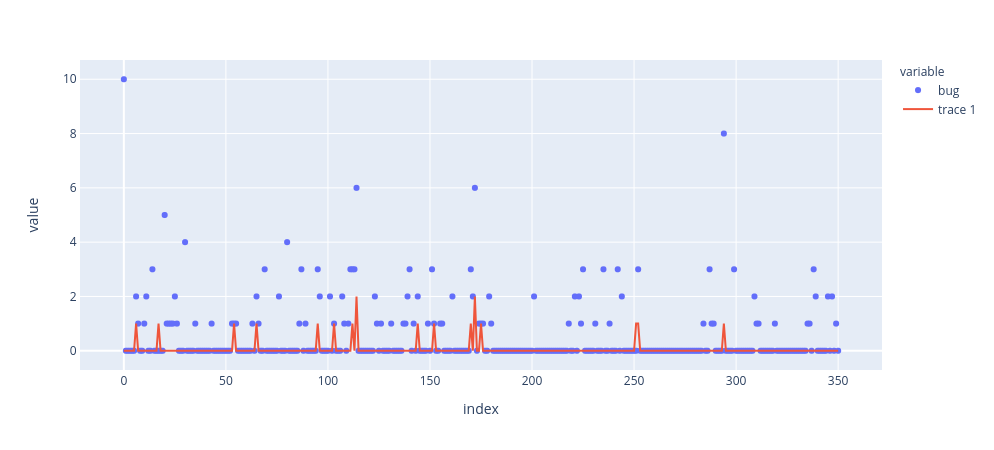

F-Measure :  0.7435897435897437
G-Mean : 0.8483847823879848
Balance : 0.8172795793110357
__________________________
PREVIOUS: 1.6
CURRENT: 1.7
DISTANCE: c
______WITH DS3_____
# Tuning hyper-parameters for precision

Best parameters set found on development set:

{'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}

Grid scores on development set:


Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

              precision    recall  f1-score   support

           0       0.82      0.91      0.86       579
           1       0.22      0.14      0.17        93
           2       0.20      0.17      0.18        30
           3       0.12      0.06      0.08        16
           4       0.00      0.00      0.00        15
           5       0.00      0.00      0.00         4
           6       0.00      0.00      0.00         4
           7       0.00      0.00      0.00         1
           8       0.00      0.00     

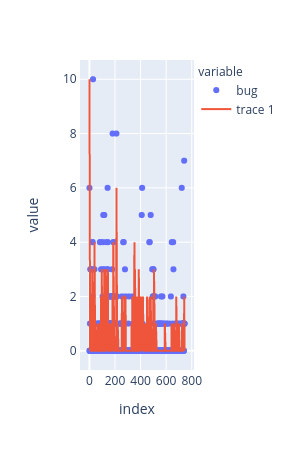

F-Measure :  0.7355704697986577
G-Mean : 0.8449607271892108
Balance : 0.8118694295638671
______WITHOUT DS3______
# Tuning hyper-parameters for precision

Best parameters set found on development set:

{'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}

Grid scores on development set:


Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

              precision    recall  f1-score   support

           0       0.82      0.90      0.86       579
           1       0.19      0.12      0.15        93
           2       0.19      0.17      0.18        30
           3       0.09      0.12      0.11        16
           4       0.00      0.00      0.00        15
           5       0.00      0.00      0.00         4
           6       0.00      0.00      0.00         4
           7       0.00      0.00      0.00         1
           8       0.00      0.00      0.00         2
          10       0.00      0.00      0.00   

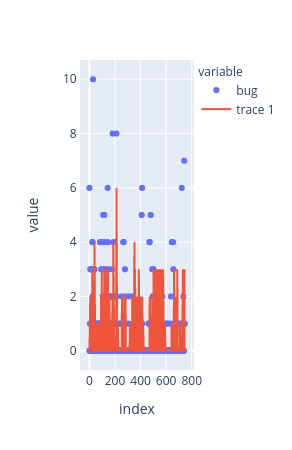

F-Measure :  0.723489932885906
G-Mean : 0.8374138195177991
Balance : 0.803274631929729


In [41]:
for v in version_tuple:
    print("__________________________")
    previous = ant_dataframe.loc[ant_dataframe.version == v[0]]
    current = ant_dataframe.loc[ant_dataframe.version == v[1]]
    previous = previous.sort_values('name').reset_index()
    current = current.sort_values('name').reset_index()
    previous = previous.drop(['index'], axis = 1)
    current = current.drop(['index'], axis = 1)
    modules_previous = previous.name.unique()
    modules_current = current.name.unique()
    for k in distances[-1]:
        print("PREVIOUS:", previous.version[0])
        print("CURRENT:", current.version[0])
        print("DISTANCE:", k)
        D = f.create_D(current, previous, features, k)
        idx = f.runDS3(D, reg = .5, verbose = False)
        print('______WITH DS3_____')
        run_Regressor(previous, current, idx, ds3 = True, verbose = True, plot = True )
        print('______WITHOUT DS3______')
        run_Regressor(previous, current, None, ds3 = False, verbose = True, plot = True )
        
 

In [ ]:
current.bug[current.bug > 0]